In [21]:
import json
import torch
from models import SewResnet18
from datasets import MNISTRepeated
from spikingjelly.activation_based import functional, layer, neuron
import matplotlib.pyplot as plt
import numpy as np

REPEATS = 10
model = SewResnet18(n_channels=1)
functional.set_step_mode(model, step_mode="m")
model.load_state_dict(torch.load("checkpoints/best_model_no_reg.pth"))
mnist_test_set = MNISTRepeated(
    root="./data", train=False, repeat=REPEATS, download=True
)


/tmp/ipykernel_487160/1618141200.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/best_model_no_reg.pth"))


In [3]:
model.parameters()

<generator object Module.parameters at 0x7ad9cc7e0eb0>

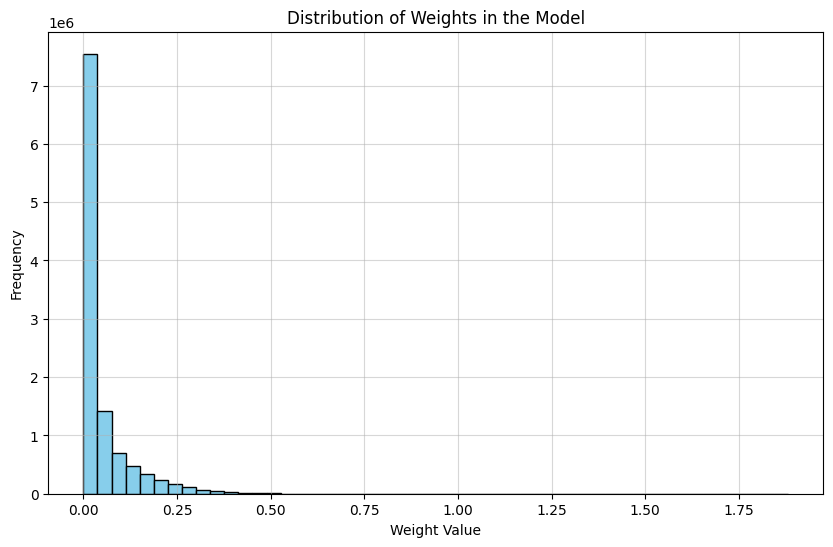

In [14]:
import torch
import matplotlib.pyplot as plt

def extract_and_analyze_weights(model):
    """
    Extracts all weights from a PyTorch model and provides basic analysis
    including printing shapes and plotting histograms.

    Args:
        model (torch.nn.Module): The PyTorch model.
    """
    all_weights = []
    for name, param in model.named_parameters():
        if param.requires_grad:  # Consider only trainable parameters (weights and biases)
            all_weights.extend(torch.abs(param.detach().cpu()).numpy().flatten())

    if all_weights:
        plt.figure(figsize=(10, 6))
        plt.hist(all_weights, bins=50, color='skyblue', edgecolor='black')
        plt.title('Distribution of Weights in the Model')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.5)
        plt.show()
    else:
        print("No trainable parameters found in the model.")


extract_and_analyze_weights(model)



In [22]:
def analyze_neuron_input_connections(model, neuron_class):
    """
    Analyzes the weights of the layers directly preceding neurons of the specified class.
    This aims to identify if neurons receive predominantly positive or negative input.

    Args:
        model (torch.nn.Module): The PyTorch model.
        neuron_class (type): The class type of the neuron layer (e.g., your LIFNode class).
    """
    neuron_input_sign = {}

    for name, module in model.named_modules():
        if isinstance(module, neuron_class):
            preceding_layer = None
            parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
            parent_module = model.get_submodule(parent_name) if parent_name else model

            # Try to find the layer that produces the output for this neuron layer
            for n, m in parent_module.named_children():
                if m is module:
                    break # Found the current neuron layer
                preceding_layer = m

            if preceding_layer is not None:
                weight = None
                if isinstance(preceding_layer, layer.Conv2d):
                    weight = preceding_layer.weight.detach().cpu().numpy()
                    # Convolutional weights have shape (out_channels, in_channels, kernel_h, kernel_w)
                    # The 'out_channels' corresponds to the number of neurons in the *next* layer (the LIFNode layer).
                    num_neurons = weight.shape[0]
                    for i in range(num_neurons):
                        neuron_weights = weight[i].flatten()
                        positive_count = np.sum(neuron_weights > 0)
                        negative_count = np.sum(neuron_weights < 0)
                        total_weights = neuron_weights.size
                        if total_weights > 0:
                            if positive_count > negative_count and negative_count == 0:
                                neuron_input_sign[f"{name}.neuron_{i}"] = "Receives Excitatory Input"
                            elif negative_count > positive_count and positive_count == 0:
                                neuron_input_sign[f"{name}.neuron_{i}"] = "Receives Inhibitory Input"
                            else:
                                neuron_input_sign[f"{name}.neuron_{i}"] = "Receives Mixed Input"
                        else:
                            neuron_input_sign[f"{name}.neuron_{i}"] = "No input weights found"
                elif isinstance(preceding_layer, layer.Linear):
                    weight = preceding_layer.weight.detach().cpu().numpy().T # Transpose for (in_features, out_features)
                    num_neurons = weight.shape[1] # out_features is the number of neurons in the LIFNode
                    for i in range(num_neurons):
                        neuron_weights = weight[:, i].flatten()
                        positive_count = np.sum(neuron_weights > 0)
                        negative_count = np.sum(neuron_weights < 0)
                        total_weights = neuron_weights.size
                        if total_weights > 0:
                            if positive_count > negative_count and negative_count == 0:
                                neuron_input_sign[f"{name}.neuron_{i}"] = "Receives Excitatory Input"
                            elif negative_count > positive_count and positive_count == 0:
                                neuron_input_sign[f"{name}.neuron_{i}"] = "Receives Inhibitory Input"
                            else:
                                neuron_input_sign[f"{name}.neuron_{i}"] = "Receives Mixed Input"
                        else:
                            neuron_input_sign[f"{name}.neuron_{i}"] = "No input weights found"
                elif preceding_layer is None:
                    print(f"Warning: Could not find preceding layer for {name}")
                else:
                    print(f"Warning: Preceding layer {preceding_layer.__class__.__name__} for {name} has weights in an unexpected format.")

    if neuron_input_sign:
        excitatory_neurons = sum(1 for status in neuron_input_sign.values() if "Excitatory" in status)
        inhibitory_neurons = sum(1 for status in neuron_input_sign.values() if "Inhibitory" in status)
        mixed_neurons = sum(1 for status in neuron_input_sign.values() if "Mixed" in status)
        total_neurons = len(neuron_input_sign)

        print(f"\nAnalysis of Input Connections to {neuron_class.__name__} Neurons:")
        for neuron, status in neuron_input_sign.items():
            print(f"Neuron {neuron}: {status}")

        print(f"\nTotal {neuron_class.__name__} Neurons Analyzed: {total_neurons}")
        print(f"  Receiving Predominantly Excitatory Input: {excitatory_neurons} ({excitatory_neurons / total_neurons * 100:.2f}%)")
        print(f"  Receiving Predominantly Inhibitory Input: {inhibitory_neurons} ({inhibitory_neurons / total_neurons * 100:.2f}%)")
        print(f"  Receiving Mixed Input: {mixed_neurons} ({mixed_neurons / total_neurons * 100:.2f}%)")

        # Optional: Visualize the distribution
        labels = 'Excitatory Input', 'Inhibitory Input', 'Mixed Input'
        sizes = [excitatory_neurons, inhibitory_neurons, mixed_neurons]
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
        plt.title(f'Distribution of Input Connection Types to {neuron_class.__name__} Neurons')
        plt.axis('equal')
        plt.show()

    else:
        print(f"No layers of type {neuron_class.__name__} found in the model.")

analyze_neuron_input_connections(model, neuron.LIFNode)

No layers of type LIFNode found in the model.
